# Serialize & Deserialize
_Simply speaking Serialization is a process of converting an Object into stream of bytes so that it can be transferred over a network or stored in a persistent storage._
http://stackoverflow.com/questions/633402/what-is-serialization

npy
Joblib
Pickle
cPickle
msgpack
csv
hdf5
json
*jsonはタプルとバイト列に対応していないが、他言語で呼び出し可能

https://github.com/bokeh/bokeh/issues/2204

ubjson is interesting in that it aims for compliance with JSON (whereas other JSON-ish formats introduce new stuff), yet they support efficient storage of typed homogeneous arrays, and with it allow storing binary data efficiently. The spec is also very simple to ease adoption. I don't think typed homogeneous arrays are parsed into JS typed arrays, but maybe we can write a JS parser that does this, and a Python parser that is numpy aware?

msgpack is a binary JSON variant aimed to be very small. They allow binary data and also extensions (which makes less incompatible with JSON). No support for typed homogeneous arrays (but could be, with an extension). Indeed there is binary-pack, which adds support for "distinct string and binary types", cannot find any docs though.

bson is another binary JSON format, that also has types like data, MD5 and more, making them not very compatible with JSON.

https://docs.python.org/2/library/pickle.html
cPickle is written in C

|pickle|marshal|json|
|---|---|---|
||ユーザ定義クラスとそのオブジェクトに非対応|カスタムクラスに非対応|
||再帰的オブジェクトに非対応||
||pythonのバージョン互換なし||
|バイナリ|バイナリ|テキスト|
|python固有|python固有|色々使える|

|Database|画像サイズ|Format|URL|
|--------|--------|--------|--------|
|ImageNet|x,3ch|JPEG|http://image-net.org/challenges/LSVRC/2014/download-images-5jj5.php|
|MNIST|28x28,1ch|binary|http://yann.lecun.com/exdb/mnist/|
|CIFAR-10|32x32,3ch|10000x3072,unit8のNumPy配列(cPickle化)各行が32x32のカラー画像に対応、最初の1024entryがR、…/binary、最初のバイトがラベル、次の1024バイトがR、…、row-major orderで格納、1つのファイルに10000画像分のデータを格納|https://www.cs.toronto.edu/~kriz/cifar.html|

In [2]:
%matplotlib inline
import time
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from numpy import frombuffer

import pickle
import cPickle
import h5py
import hickle # pip install hickle
import json
import simplejson  # pip install simplejson
import ujson # pip install ujson
import bson # pip install bson, pip install PyMongo
import marshal # marshalは永続化しない
import yaml # pip install pyyaml
import joblib # pip install joblib
import msgpack # pip install msgpack-python
import msgpack_numpy as m # pip install msgpack_numpy
import csv
import scipy
from base64 import urlsafe_b64encode, urlsafe_b64decode
import scipy
from scipy.io import savemat, loadmat

In [3]:
nb_files = 100
width = 224
height = 224
channel = 3
data = np.random.random((nb_files,width,height,channel))
#data = np.random.random((2,2)).astype(np.float16)
#data = 'hello' * 10000
#sparsity = 0.8
#data = data * (data>sparsity)
#print np.sum(data!=0), np.sum(data==0), float(np.sum(data==0))/float(np.size(data))

In [4]:
'''
S0 = scipy.sparse.bsr_matrix(data)
S1 = scipy.sparse.coo_matrix(data)
S2 = scipy.sparse.csc_matrix(data)
S3 = scipy.sparse.csr_matrix(data)
S4 = scipy.sparse.dia_matrix(data)
S5 = scipy.sparse.dok_matrix(data)
S6 = scipy.sparse.lil_matrix(data)

#with open('workfile', 'wb') as f:
#    scipy.sparse.save_npz(f, S0)
'''

"\nS0 = scipy.sparse.bsr_matrix(data)\nS1 = scipy.sparse.coo_matrix(data)\nS2 = scipy.sparse.csc_matrix(data)\nS3 = scipy.sparse.csr_matrix(data)\nS4 = scipy.sparse.dia_matrix(data)\nS5 = scipy.sparse.dok_matrix(data)\nS6 = scipy.sparse.lil_matrix(data)\n\n#with open('workfile', 'wb') as f:\n#    scipy.sparse.save_npz(f, S0)\n"

In [5]:
datasize = sys.getsizeof(data)
print datasize, 'bytes'
print float(datasize)/1024./1024./1024., 'GB'

120422544 bytes
0.11215223372 GB


In [6]:
def measure_serialize_speed(serializer, fileName, isremove=True):
    
    print serializer.name
    
    if os.path.exists(fileName):
        os.remove(fileName)

    start = time.time()
    serializer.dump(data, fileName)
    end = time.time()
    dump_time = end-start
    print 'dump ', dump_time, ' s'

    filesize=0
    if os.path.exists(fileName):
        filesize = os.path.getsize(fileName)
    print 'file size ', filesize, ' byte'

    start = time.time()
    serializer.load(fileName)
    end = time.time()
    load_time = end-start
    print 'load ', load_time, ' s'
    print 

    if isremove and os.path.exists(fileName):
        os.remove(fileName)
    
    return serializer.name, dump_time, load_time, filesize

In [7]:
class Csv(object):
    name = 'csv'
    shape = None
    def dump(self, data, path):
        if isinstance(data,np.ndarray):
            if np.ndim(data) <= 2:
                np.savetxt(path, data)
            else:
                shape = np.shape(data)
                np.savetxt(path, np.reshape(data,(np.shape(data)[0],np.size(data)/np.shape(data)[0])))
        else:
            with open(path, mode='wb') as f:
                writer = csv.writer(f, lineterminator='\n')
                writer.writerows(data)
    def load(self, path):
        pd.read_csv(path)
#        if isinstance(data,np.ndarray):
#            if np.ndim(data) <= 2:
#                np.loadtxt(path)
#            else:
#                d = np.loadtxt(path)
#                d = np.reshape(d, self.shape)

class Npy(object):
    name = 'npy'
    def dump(self, data, path):
        np.save(path, data)
    def load(self, path):
        np.load(path)

class Npz(object):
    name = 'npz'
    def dump(self, data, path):
        np.savez(path, data)
    def load(self, path):
        np.load(path)

class Npz_c(object):
    name = 'npz_c'
    def dump(self, data, path):
        np.savez_compressed(path, data)
    def load(self, path):
        np.load(path)

class H5py(object):
    name = 'h5py'
    dir = 'sample'
    group = 'random'
    def dump(self, data, path):
        h5file = h5py.File(path,'w')
        h5file.create_group(self.dir)
        h5file.create_dataset(self.dir+'/'+self.group,data=data)
        h5file.flush()
        h5file.close()
    def load(self, path):
        h5file = h5py.File(path,'r')
        h5file[self.dir+'/'+self.group].value
        h5file.close()

class Pickle0(object):
    name = 'pickle_0'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            pickle.dump(data, f, protocol=0)
    def load(self, path):
        with open(path, mode='rb') as f:
            pickle.load(f)

class Pickle1(object):
    name = 'pickle_1'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            pickle.dump(data, f, protocol=1)
    def load(self, path):
        with open(path, mode='rb') as f:
            pickle.load(f)

class Pickle2(object):
    name = 'pickle_2'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            pickle.dump(data, f, protocol=2)
    def load(self, path):
        with open(path, mode='rb') as f:
            pickle.load(f)

class Cpickle2(object):
    name = 'cPickle_2'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            cPickle.dump(data, f, protocol=2)
    def load(self, path):
        with open(path, mode='rb') as f:
            cPickle.load(f)

class Hickle(object):
    name = 'hickle'
    def dump(self, data, path):
        with open(path, mode='w') as f:
            hickle.dump(data, f)
    def load(self, path):
        hickle.load(path)

class Joblib(object):
    name = 'joblib'
    def dump(self, data, path):
        joblib.dump(data, path, compress=0)
    def load(self, path):
        joblib.load(path)

class Msgpack(object):
    name = 'msgpack'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            msgpack.dump(data, f, default=m.encode)
    def load(self, path):
        with open(path, mode='rb') as f:
            msgpack.load(f, object_hook=m.decode)
            
class Json(object):
    name = 'json'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            if isinstance(data,np.ndarray):
                json.dump(data.tolist(), f)
            else:
                json.dump(data, f)
    def load(self, path):
        with open(path, mode='rb') as f:
            json.load(f)

class Simplejson(object):
    name = 'simplejson'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            if isinstance(data,np.ndarray):
                simplejson.dump(data.tolist(), f)
            else:
                simplejson.dump(data, f)
    def load(self, path):
        with open(path, mode='rb') as f:
            simplejson.load(f)

class Ujson(object):
    name = 'ujson'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            if isinstance(data,np.ndarray):
                ujson.dump(data.tolist(), f)
            else:
                ujson.dump(data, f)
    def load(self, path):
        with open(path, mode='rb') as f:
            ujson.load(f)

class Bson2(object):
    name = 'bson2'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            if isinstance(data,np.ndarray):
                f.write(bson.json_util.dumps(data.tolist()))
            else:
                f.write(bson.dumps(data))
    def load(self, path):
        with open(path, mode='rb') as f:
            f.read()

class Bson(object):
    name = 'bson'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            if isinstance(data,np.ndarray):
                f.write(bson.BSON.encode({'a':data.tolist()}))
            else:
                f.write(bson.BSON.encode({'a':data}))
    def load(self, path):
        bson.decode_all(open(path,'rb').read())[0]['a']

class Marshal(object):
    name = 'marshal'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
            marshal.dump(data, f)
    def load(self, path):
        with open(path, mode='rb') as f:
            marshal.load(f)
            
class Yaml(object):
    name = 'yaml'
    def dump(self, data, path):
        with open(path, mode='wb') as f:
#            yaml.dump(data.tolist(), f)
            yaml.dump(data, f)
    def load(self, path):
        with open(path, mode='rb') as f:
            yaml.load(f)

class Base64(object):
    name = 'base64'
    def dump(self, data, path):
        with open(path, 'w') as f:
            f.write(b'{0:s} {1:d} {2:d}\n'.format(data.dtype, *data.shape))
            f.write(urlsafe_b64encode(data.data))
    
    def load(self, path):
        with open(path, 'r') as f:
            dtype, w, h = str(f.readline()).split()
            return frombuffer(urlsafe_b64decode(f.read()), dtype=dtype).reshape((int(w), int(h)))
        
class Binary(object):
    name = 'binary'
    def dump(self, data, path):
        with open(path, 'wb') as f:
            for d in data:
                f.write(chr(d))
    
    def load(self, path):
        with open(path, 'rb') as f:
            f.read()

class Mat(object):
    name = 'mat'
    def dump(self, data, path):
        with open(path, 'wb') as f:
            savemat(f, dict(data=data))
    
    def load(self, path):
        with open(path, 'rb') as f:
            loadmat(f)['data']

In [8]:
n,d,l,s = measure_serialize_speed(Npz(), 'dat.npz', False)

npz
dump  0.832619905472  s
file size  120422612  byte
load  0.000114917755127  s



In [9]:
columns=['Serializer','dump','load','file size']
df = pd.DataFrame(columns=columns)

isRemoved = True

for i in range(10):

    n,d,l,s = measure_serialize_speed(Csv(), 'dat.csv', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Npy(), 'dat.npy', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Npz(), 'dat.npz', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Npz_c(), 'dat_c.npz', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(H5py(), 'dat.h5', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Pickle0(), 'dat.pkl0', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Pickle1(), 'dat.pkl1', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Pickle2(), 'dat.pkl2', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Cpickle2(), 'dat.cpkl', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Hickle(), 'dat.hickle', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Bson(), 'dat.bson', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Ujson(), 'dat.ujson', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Simplejson(), 'dat.sjson', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Json(), 'dat.json', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Joblib(), 'dat.jlib', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Msgpack(), 'dat.msg', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))
    
    n,d,l,s = measure_serialize_speed(Yaml(), 'dat.yml', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))
    
    n,d,l,s = measure_serialize_speed(Marshal(), 'dat.msl', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

    n,d,l,s = measure_serialize_speed(Mat(), 'dat.mat', isRemoved)
    df = df.append(pd.DataFrame([[n,d,l,s]], columns=columns))

df['Serializer']=df['Serializer'].astype('category')
df['file size']=df['file size']/datasize
df

csv
dump  8.96596097946  s
file size  376320000  byte
load  4.44779610634  s

npy
dump  0.0360579490662  s
file size  120422496  byte
load  0.0276739597321  s

npz
dump  0.203378915787  s
file size  120422612  byte
load  0.00023889541626  s

npz_c
dump  3.86190295219  s
file size  113559393  byte
load  0.000104904174805  s

h5py
dump  0.195219039917  s
file size  120424872  byte
load  0.0420949459076  s

pickle_0
dump  4.45489192009  s
file size  334435819  byte
load  1.67028999329  s

pickle_1
dump  0.0739948749542  s
file size  120422563  byte
load  0.0453689098358  s

pickle_2
dump  0.0774149894714  s
file size  120422559  byte
load  0.0455219745636  s

cPickle_2
dump  0.0548028945923  s
file size  120422539  byte
load  0.0647709369659  s

hickle
dump  0.0470378398895  s
file size  120428640  byte
load  0.0574090480804  s

bson
dump  9.59908103943  s
file size  213506703  byte
load  3.46384906769  s

ujson
dump  4.54903507233  s
file size  204092442  byte
load  3.84313297272  s

sim

,Serializer,dump,load,file size
0,csv,8.965961,4.447796,3.124996
0,npy,0.036058,0.027674,1.000000
0,npz,0.203379,0.000239,1.000001
0,npz_c,3.861903,0.000105,0.943008
0,h5py,0.195219,0.042095,1.000019
0,pickle_0,4.454892,1.670290,2.777186
0,pickle_1,0.073995,0.045369,1.000000
0,pickle_2,0.077415,0.045522,1.000000
0,cPickle_2,0.054803,0.064771,1.000000
0,hickle,0.047038,0.057409,1.000051


In [37]:
'{: .2f}'.format(1.234)

' 1.23'

In [70]:
def annotated_bar_plot(df, y, figsize=(10,10), ylim=None, annot=True):
    fig, ax = plt.subplots(1, figsize=figsize)
    g = sns.barplot(data=df, x='Serializer', y=y)
    groupedvalues = df.groupby('Serializer').mean().reset_index()
    if ylim==None:
        if annot:
            for index, row in groupedvalues.iterrows():
                g.text(x=row.name, y=row[y], s=row[y], color='black', ha="center")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    else:
        if annot:
            for index, row in groupedvalues.iterrows():
    #            g.text(x=row.name, y=min(row[y],ylim), s=row[y], color='black', ha="center")
                if row[y]>ylim:
                    g.text(x=row.name, y=min(row[y],ylim), s='{: .2f}'.format(row[y]), color='black', ha="center")
        plt.ylim(0,ylim)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

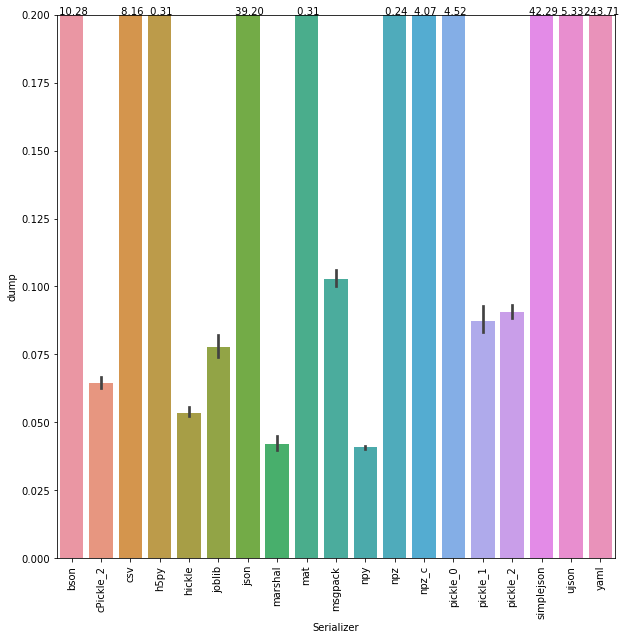

In [71]:
annotated_bar_plot(df, 'dump', ylim=0.2)

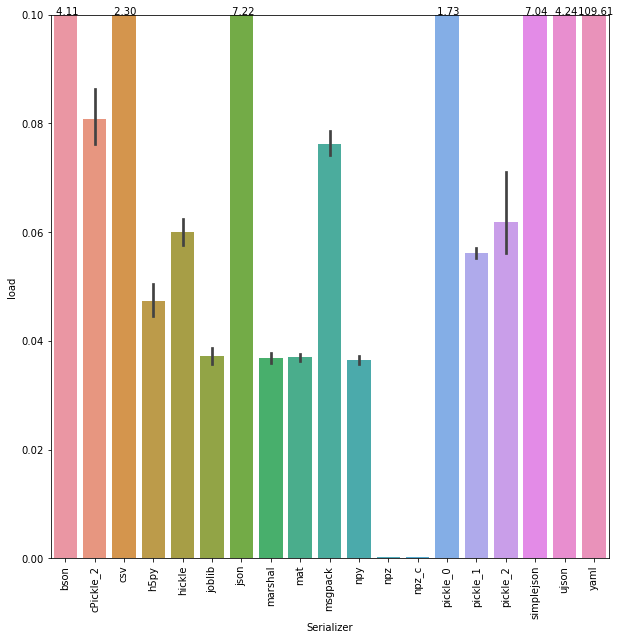

In [72]:
annotated_bar_plot(df, 'load', ylim=0.1)

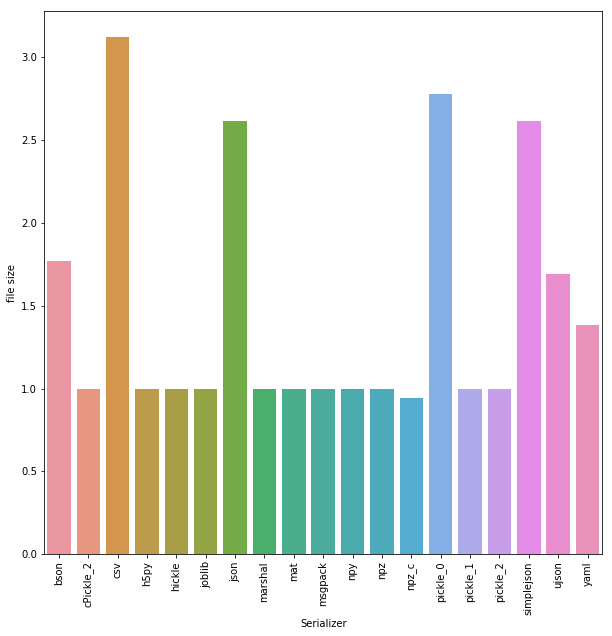

In [73]:
annotated_bar_plot(df, 'file size', annot=False)

In [14]:
#df.sort('dump')
df.groupby('Serializer').mean().sort('dump').reset_index()

/home/ruho/anaconda2/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Serializer,dump,load,file size
0,marshal,0.037780,0.033228,0.999999
1,npy,0.038869,0.032759,1.000000
2,hickle,0.054235,0.054016,1.000051
3,cPickle_2,0.059166,0.071056,1.000000
4,joblib,0.065596,0.036790,1.000000
5,pickle_1,0.079266,0.051546,1.000000
6,pickle_2,0.084967,0.053630,1.000000
7,msgpack,0.098837,0.073249,0.999999
8,npz,0.219933,0.000258,1.000001
9,h5py,0.243917,0.047135,1.000019


In [15]:
#df.sort('load')
df.groupby('Serializer').mean().sort('load').reset_index()

/home/ruho/anaconda2/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Serializer,dump,load,file size
0,npz_c,3.905260,0.000151,0.943008
1,npz,0.219933,0.000258,1.000001
2,npy,0.038869,0.032759,1.000000
3,marshal,0.037780,0.033228,0.999999
4,joblib,0.065596,0.036790,1.000000
5,mat,0.295904,0.038829,1.000000
6,h5py,0.243917,0.047135,1.000019
7,pickle_1,0.079266,0.051546,1.000000
8,pickle_2,0.084967,0.053630,1.000000
9,hickle,0.054235,0.054016,1.000051


In [16]:
#df.sort('file size')
df.groupby('Serializer').mean().sort('file size').reset_index()

/home/ruho/anaconda2/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Serializer,dump,load,file size
0,npz_c,3.905260,0.000151,0.943008
1,marshal,0.037780,0.033228,0.999999
2,msgpack,0.098837,0.073249,0.999999
3,npy,0.038869,0.032759,1.000000
4,cPickle_2,0.059166,0.071056,1.000000
5,pickle_2,0.084967,0.053630,1.000000
6,pickle_1,0.079266,0.051546,1.000000
7,mat,0.295904,0.038829,1.000000
8,joblib,0.065596,0.036790,1.000000
9,npz,0.219933,0.000258,1.000001


In [18]:
from pivottablejs import pivot_ui
import pandas as pd
df = pd.read_pickle('io_speed.pickle')
pivot_ui(df)

In [19]:
df.to_pickle('io_speed.pickle')